# Exploratory Data Analysis

In this notebook, we will explore how sentiment and topic are changing over time.<br><br>
note:<br>
-- topics are generated from our best model, which is NMF model.<br> 
-- Data is gathered in three-month intervals to analyze trends.

In [1]:
import sys
sys.path.insert(0, '..')
import os
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import src.transformations as c
from src.topic_modelling.train.train_nmf import train_nmf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zyn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# loading data
current_path = os.getcwd()
root_path = os.path.dirname(current_path)
df = pd.read_csv(root_path + '/data/reviews.csv', encoding='unicode_escape')

In [3]:
# label raw data with topics
df['stem_clean_text'] = df['Text'].apply(lambda x: c.get_cleantext(x, stemming=True))
num_topics = 20
n_top_words = 10
nmf_topic_words, nmf_pred, nmf_model = train_nmf(df, num_topics=num_topics, n_top_words=n_top_words)
df['nmf_pred'] = nmf_pred

In [4]:
df['Time'] = pd.to_datetime(df['Time'])

## Sentiment analysis

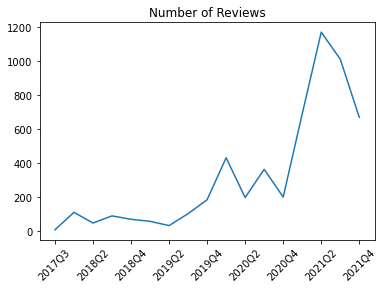

In [5]:
df['Time'].dt.to_period('Q').astype('str').value_counts().sort_index().plot()
plt.title('Number of Reviews')
plt.xticks(rotation = 45)
plt.show()

This chart illustrates that the review data generally increases over time, reaching its peak in the second quarter of 2021 and then declining.

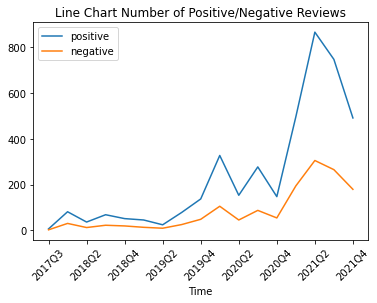

In [6]:
df[df['Sentiment']=='positive'].groupby([df["Time"].dt.to_period('Q').astype('str')]).size().plot(kind="line", label='positive')
df[df['Sentiment']=='negative'].groupby([df["Time"].dt.to_period('Q').astype('str')]).size().plot(kind="line", label='negative')
plt.legend(loc="upper left")
plt.title('Line Chart Number of Positive/Negative Reviews')
plt.xticks(rotation = 45)
plt.show()

The number of positive reviews are always more than negative ones.

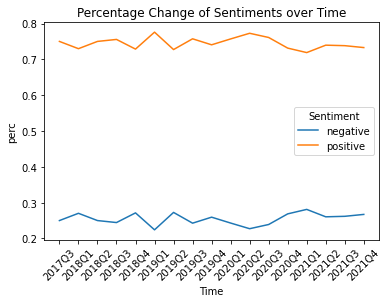

In [7]:
# create table with time as column and percentage of positive and negative reviews as features.
df_count = df.groupby([df["Time"].dt.to_period('Q').astype('str'),df['Sentiment']], as_index=False).size()
df_count['perc']=df_count['size'] / df_count.groupby('Time')['size'].transform('sum')
sns.lineplot(data=df_count, x='Time', y='perc', hue='Sentiment').set(title='Percentage Change of Sentiments over Time')
plt.xticks(rotation=45)
plt.show()

Since the number of review of each quarter changes over time, we tried to use percentage of positive/negative reviews to better see the trend. It shows that percentage of positive reviews were fluctuating around 75%, and slightly decreased in 2021.

### Word Cloud for Positive/Negative Sentiments

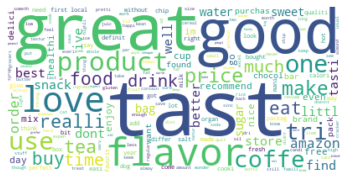

In [8]:
text = ','.join(list(df[df['Sentiment']=='positive']['stem_clean_text'].values))
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

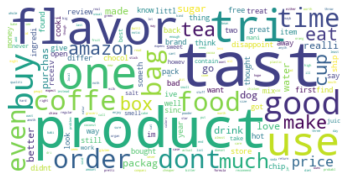

In [9]:
text = ','.join(list(df[df['Sentiment']=='negative']['stem_clean_text'].values))
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This two word clounds shows that people always use words like good, great when they are satisfied with the product, and they placed a strong emphasis on the taste.

## Topic Analysis

In [10]:
# decoding index into text
topics={0: 'Taste', 1: 'Coffee', 2: 'Tea', 3:'Amazon', 4: 'Taste/Price', 5: 'Healthy Snacks', 6: 'Dog Food', 7 : 'Healthy Carbohydrates',
         8: 'Cold Beverages', 9: 'Hot Beverages', 10: 'Flavour', 11: 'Chips',12: 'Delivery Feedback', 13: 'Taste', 14: 'Saltiness',
         15: 'Recommendation',16: 'Trying', 17: 'Alternatives', 18: 'Cat/ Baby Food', 19: 'Cooking Ingredients'}

In [11]:
df['topic']=df['nmf_pred'].map(topics)

### Word Cloud for Different Topics

In [12]:
def display_wordclouds(df, pred_col, num_topics):
    fig = plt.figure(figsize=(20,10))
    j = int(np.ceil(num_topics/4))
    for t in range(num_topics):
        # Join the different processed titles together.
        long_string = ','.join(list(df[df[pred_col]==t]['stem_clean_text'].values))
        # Create a WordCloud object
        wordcloud = WordCloud(width=700, height=250, 
                              background_color="white", 
                              max_words=500)
        if len(long_string)==0:
            long_string = 'None'
        # Generate a word cloud
        wordcloud.generate(long_string)
        i=t+1
        plt.subplot(j, 4, i).set_title(topics[t])
        plt.plot()
        plt.imshow(wordcloud)
        plt.axis("off")
    # plt.title(pred_col[:3].upper() + " Topics")
    plt.suptitle(pred_col[:3].upper() + " Topics", fontsize=30)
    plt.tight_layout()
    plt.show()

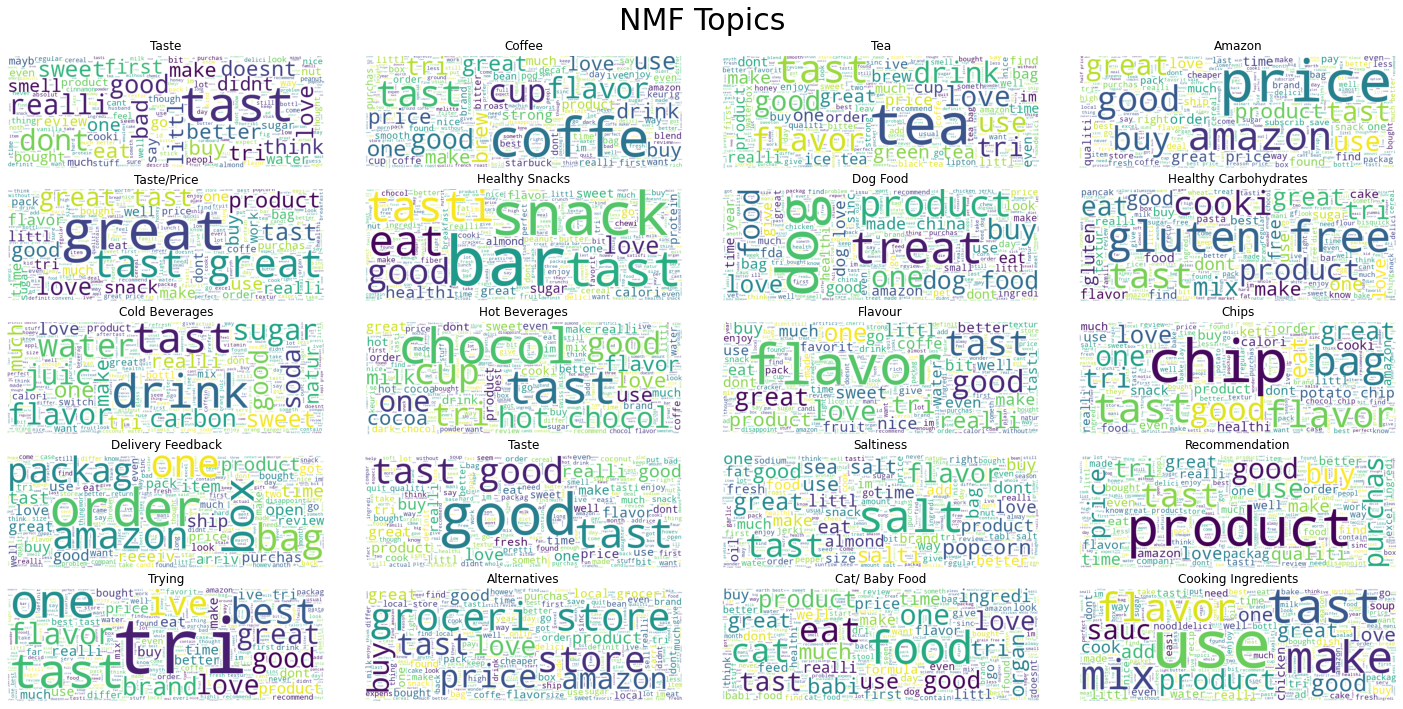

In [13]:
display_wordclouds(df, 'nmf_pred', num_topics=num_topics)

Word cloud of each topic was shown above. Words of larger size indicates higher frequency. By analyzing the top 10 words in each topic, we can easily label them.

### Topics Distribution

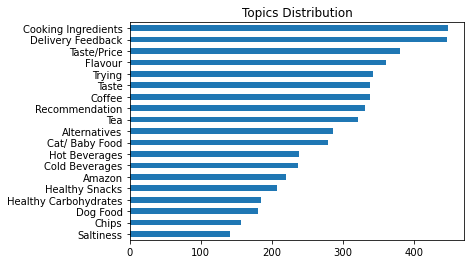

In [14]:
df['topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Topics Distribution')
plt.show()

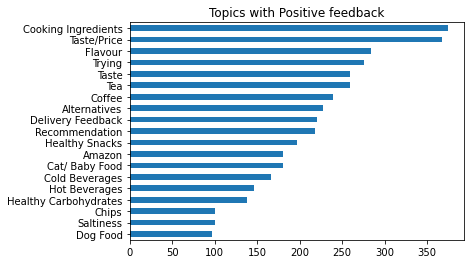

In [15]:
df[df['Sentiment']=='positive']['topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Topics with Positive feedback')
plt.show()

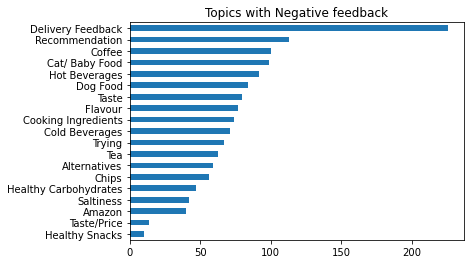

In [16]:
df[df['Sentiment']=='negative']['topic'].value_counts().sort_values().plot(kind='barh')
plt.title('Topics with Negative feedback')
plt.show()

Bar plots above shows that the most popular topics were cooking ingridients, delivery feedback, and taste/price.
In positive reviews, the taste is the most frequently discussed aspect, while in negative reviews, transportation is mentioned the most.

In [17]:
# calculate percentage of positive/negative reviews under each topic
df_topic = df.groupby([df['topic'],df['Sentiment']], as_index=False).size()
df_topic['perc']=df_topic['size'] / df_topic.groupby('topic')['size'].transform('sum')
topic_perc=pd.pivot_table(df_topic, values='perc', index='topic', columns='Sentiment')

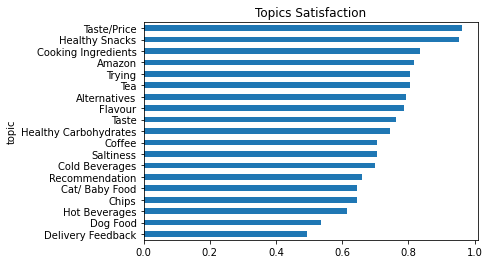

In [18]:
topic_perc['positive'].sort_values().plot(kind='barh')
plt.title('Topics Satisfaction')
plt.show()

After we calculatng percentage of positive feedbacks under each topic, it was shown that taste/price was most satisfying, and delivery was the least satisfying.

### Popular Topics over Time

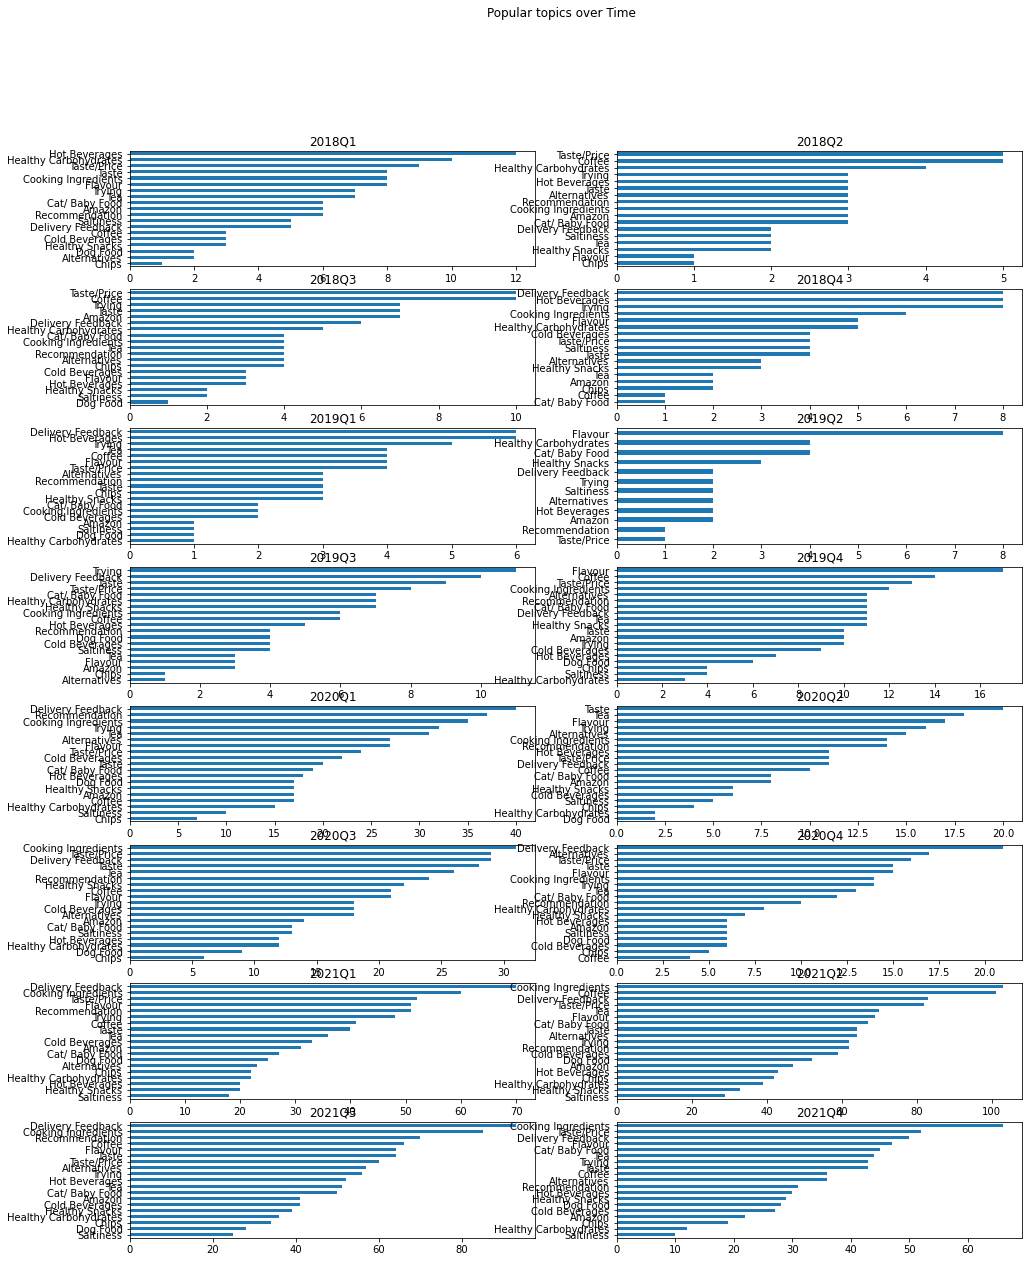

In [19]:
Period = np.unique(df["Time"].dt.to_period('Q').astype('str')).tolist()[1:]
fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(16,20))
for i in range(16):
        plt.subplot(8, 2, i+1).set_title(Period[i])
        df[df["Time"].dt.to_period('Q').astype('str')==Period[i]]['topic'].value_counts().sort_values().plot(kind='barh')
fig.suptitle('Popular topics over Time')
plt.show()

2017Q3 was removed when analyzing topics over time, because of too few number of reviews, and we got 16 time periods in total.As shown in the plot above, healthy carbohydrates and hot beverage were popular in 2018 and first half of 2019, and cooking ingridients became popular since 2019Q4. Taste, flavor and delivery were always popular topics.